In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('road_accident.csv')

In [3]:
data.head()

,Date,Time,Day_of_Week,Barangay,Latitude,Longitude,Weather,Road_Condition,Vehicle_Type,Driver_Age,Driver_Gender,Accident_Type,Injuries,Fatalities
0,04/08/2021,21:15,Wednesday,I-C (Bagong Bayan),14.071215,121.322198,Sunny,Dry,Motorcycle,44,Male,Head-on collision,4,0
1,20/08/2021,7:15,Friday,Santa Veronica (Bae),14.080453,121.330692,Sunny,Dry,Bicycle,38,Male,Rear-end collision,1,1
2,05/09/2023,3:32,Tuesday,I-A (Sambat),14.080712,121.301354,Rainy,Wet,Car,29,Female,Side-impact collision,2,0
3,14/12/2021,15:08,Tuesday,VI-A (Mavenida),14.047567,121.298669,Rainy,Wet,Motorcycle,50,Male,Side-impact collision,5,0
4,05/02/2020,13:01,Wednesday,San Lucas 2 (Malinaw),14.080015,121.329899,Rainy,Wet,Motorcycle,27,Male,Head-on collision,2,0


In [4]:
data.columns

Index(['Date', 'Time', 'Day_of_Week', 'Barangay', 'Latitude', 'Longitude',
       'Weather', 'Road_Condition', 'Vehicle_Type', 'Driver_Age',
       'Driver_Gender', 'Accident_Type', 'Injuries', 'Fatalities'],
      dtype='object')

In [5]:
data.shape

(1500, 14)

In [8]:
X = data.drop('Accident_Type', axis=1)
y = data['Accident_Type']

In [9]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [10]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [11]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Latitude', 'Longitude', 'Driver_Age', 'Injuries', 'Fatalities'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Date', 'Time', 'Day_of_Week', 'Barangay', 'Weather', 'Road_Condition',
       'Vehicle_Type', 'Driver_Gender'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [14]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


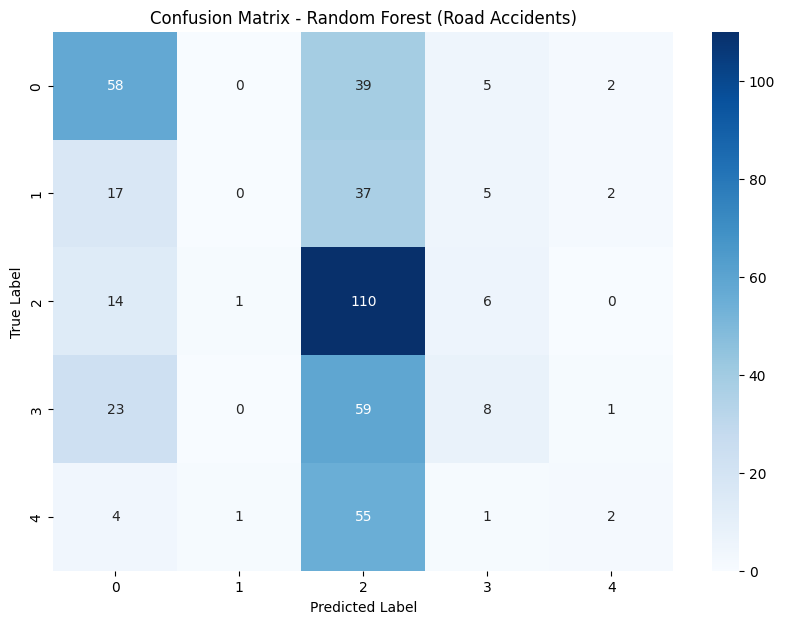

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Road Accidents)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

      Head-on collision       0.50      0.56      0.53       104
    Pedestrian accident       0.00      0.00      0.00        61
     Rear-end collision       0.37      0.84      0.51       131
  Side-impact collision       0.32      0.09      0.14        91
Single vehicle accident       0.29      0.03      0.06        63

               accuracy                           0.40       450
              macro avg       0.29      0.30      0.25       450
           weighted avg       0.33      0.40      0.31       450



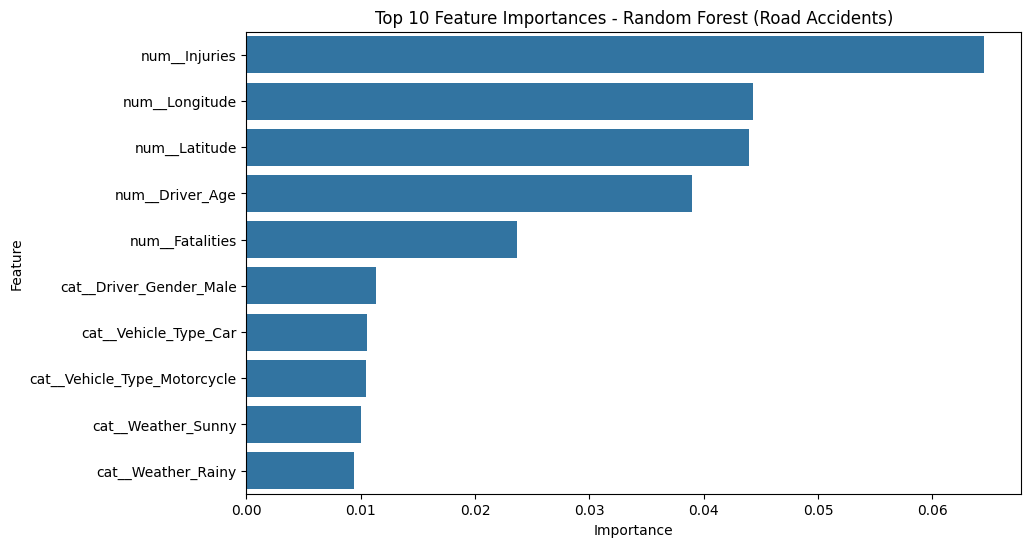

In [19]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['classifier'].feature_importances_
feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance = feat_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10))
plt.title('Top 10 Feature Importances - Random Forest (Road Accidents)')
plt.show()

In [20]:
joblib.dump(model, 'rf_road_accident.pkl')
print("Model saved as 'rf_road_accident.pkl'")

Model saved as 'rf_road_accident.pkl'
